In [1]:
from ip_geo2 import *

/home/jsaxon/anaconda3/envs/aws/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Plotting Macro.

In [2]:
import matplotlib.ticker as mticker

colors = {
    "mm" : "#128BE9", "ip" : "#0C3B7C",
    "comcast" : "#000000", "verizon" : "#cf1c1a", 
    "att" : "#1391d2", "sprint" : "#fdbf0e", "tmobile" : "#db006c",
    "charter" : "#144d8a", "cablevision" : "#ff3333", "rcn" : "#371b82"
}

labels = {
    "mm" : "MaxMind", "ip" : "IP2Location",
    "comcast" : "Comcast", "verizon" : "Verizon", 
    "att" : "AT&T", "sprint" : "Sprint", "tmobile" : "T-Mobile",
    "charter" : "Charter", "rcn" : "RCN", "cablevision" : "Cablevision"
}

bins = list(np.arange(0, 10, 0.01).round(2)) + \
       list(np.arange(10, 100, 0.1).round(1)) + \
       list(range(100, 1000, 1)) + list(range(1000, 20000, 10))

args = {"cumulative" : True, "density" : 1, "bins" : bins, "histtype" : "step", "lw" : 1.5}

leg_args = {"loc" : "lower right", "facecolor" : "w", "framealpha" : 1, "frameon" : True}

dots = (0, (1, 0)), (0, (2, 5)), (2, (2, 2))

def get_cdf_plot(kv, leg = True, cmap = None, ax = None, save = ""):

    if not ax: fig, ax = plt.subplots()

    if cmap: cmap = plt.get_cmap(cmap)

    for ki, (k, v) in enumerate(kv.items()):
        
        label = k    if k not in labels else labels[k]
        ls    = "-"  if len(kv) > 3     else dots[ki]
        
        color = None
        if k in colors: color = colors[k]
        if cmap:
            color = "#{:02X}{:02X}{:02X}".format(*[int(v*255) for v in cmap(ki/(len(kv)-1))])
        
        v.hist(label = label, color = color, ls = ls, ax = ax, **args)
        

    if leg: ax.legend(**leg_args)
        
    ax.set_xlim(1, 3000)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.set_xlabel("GPS to Geolocated IP [km]")
    ax.set_ylabel("Cumulative Density")
    
    if save: ax.figure.savefig("figs/{}.pdf".format(save))
    if save: ax.figure.savefig("figs/{}.png".format(save), dpi = 300)
    
    return ax

### Analysis...

#### Get the data...

In [3]:
data_types = {
    'identifier'      : str,
    'lat'             : float,
    'lon'             : float,
    'local_date_time' : str,
    'duration'        : int,
    'bump_count'      : int,
    'classification'  : str,
    'ip_address'      : str,
    'x'               : int,
    'y'               : int,
    'geoid'           : int,
    'night'           : bool,
    'out_of_home'     : bool,
    'subnet'          : str,
    'CIDR'            : str,
    'DBA'             : str,
    'mm_lat'          : float,
    'mm_lon'          : float,
    'mm_acc'          : float,
    'ip2loc_lat'      : float,
    'ip2loc_lon'      : float,
    'mm_ip_dist'      : float,
    'gps_ip_dist'     : float,
    'gps_mm_dist'     : float,
    'ASN'             : int
}

usecols = ["identifier", "lat", "lon", "x", "y", 
           "classification", "geoid", "night", "out_of_home", "ip_address", "subnet", "DBA", 
           "mm_ip_dist", "gps_ip_dist", "gps_mm_dist", 
           "mm_lat", "mm_lon", "mm_acc", "ip2loc_lat", "ip2loc_lon"]

data_types = {k : v for k, v in data_types.items() if k in usecols}

In [4]:
chicago_ip  = pd.read_csv("data/chicago_ip_only.csv.bz2", dtype = data_types, usecols = usecols)
new_york_ip = pd.read_csv("data/new_york_ip_only.csv.gz", dtype = data_types, usecols = usecols)

city_ip = {"chicago"  : chicago_ip, "new_york" : new_york_ip}

In [5]:
for k, v in city_ip.items(): print(k, v.memory_usage().sum() / 1e9)

chicago 2.283996972
new_york 5.073065194


A few of the non-IANA-special CIDRs are missing when using the pyasn approach.  Most of these are DoD addresses, but some are T-Mobile.  They are not dominantly IPv4 or IPv6.

### What about Unacast as a data source?

In [6]:
dict_eval = lambda f: {k : f(v) for k, v in city_ip.items()}
df_eval   = lambda f: pd.DataFrame(dict_eval(f))

What fraction are RIPE, LACNIC, APNIC, AfriNIC?  Really low....

In [7]:
foreign_nic = ["RIPE", "AFRINIC", "APNIC", "LACNIC"]

out_of_arin = lambda df: df.query("DBA in @foreign_nic").groupby("DBA").DBA.count() / df.DBA.count()

df_eval(out_of_arin)

,chicago,new_york
DBA,,
AFRINIC,0.000060,0.000088
APNIC,0.000107,0.000457
LACNIC,0.000256,0.000463
RIPE,0.000616,0.004846


However, there is a modest fraction that from local networks, loopback etc -- 

In [8]:
dict_eval(lambda df: df.ip_address.str.startswith("10.").mean())

{'chicago': 0.009469749512491007, 'new_york': 0.007088089652347463}

In [9]:
dict_eval(lambda df: df.DBA.str.startswith("IANA").mean())

{'chicago': 0.040385472940493015, 'new_york': 0.0707468181330418}

We should really drop those!!

In [10]:
for v in city_ip.values(): v.query("DBA != 'IANA'", inplace = True)

What share of unique addresses are IPV4?

In [ ]:
is_ipv4 = lambda df: df.ip_address.str.contains(".").sum() / df.shape[0]
is_ipv6 = lambda df: df.ip_address.str.contains(":").sum() / df.shape[0]
    
dict_eval(is_ipv4)

What share of locations are IPV4?

In [ ]:
is_ipv4 = lambda df: df.ip_address.unique().str.contains(".").sum() / df.ip_address.unique().shape[0]
is_ipv6 = lambda df: df.ip_address.unique().str.contains(":").sum() / df.ip_address.unique().shape[0]
    
dict_eval(is_ipv4)

How does Unacast classify these locations?

In [11]:
df_eval(lambda df: df.classification.value_counts())

,chicago,new_york
AREA_DWELL,3714976,8048209
LARGE_VARIANCE,2299,13053
LONG_AREA_DWELL,2244094,4744884
MOVING,294,602
PING,889220,2330345
POTENTIAL_AREA_DWELL,1925629,4841657
SHORT_AREA_DWELL,2590504,5588976
SPLIT,36,125
TRAVEL,3644982,6865072


Do we do any better on Comcast accuracies by restricting ourselves to night pings with long durations, etc.?

In [12]:
chicago_localized_subnets = ["98.222.252.0", "98.227.229.0", "73.209.252.0", "50.200.11.0", "76.16.225.0", 
                             "98.206.197.0", "24.14.202.0",  "24.1.42.0",    "24.1.164.0", "67.175.34.0"]

chicago_ip["localized_comcast"] = chicago_ip.subnet.isin(chicago_localized_subnets)

localized_comcast = chicago_ip.query("localized_comcast")

In [13]:
localized_comcast.groupby("classification").classification.count()

classification
AREA_DWELL              3882
LONG_AREA_DWELL         2267
PING                     526
POTENTIAL_AREA_DWELL    1360
SHORT_AREA_DWELL         737
TRAVEL                   814
Name: classification, dtype: int64

In [14]:
localized_comcast[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     4.055752
gps_ip_dist    21.773942
dtype: float64

In [15]:
localized_comcast.query("classification != 'TRAVEL'")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     3.989544
gps_ip_dist    21.893240
dtype: float64

In [16]:
dwell_types = ["LONG_AREA_DWELL", "SHORT_AREA_DWELL"]

localized_comcast.query("classification in @dwell_types")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     4.426306
gps_ip_dist    23.293778
dtype: float64

In [17]:
localized_comcast.query("classification == 'LONG_AREA_DWELL'")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     4.730858
gps_ip_dist    21.660193
dtype: float64

In [18]:
localized_comcast.query("night > 0")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     5.309207
gps_ip_dist    21.062891
dtype: float64

Now what about with things night-time or home activity?

In [19]:
chicago_ip.query("DBA == 'Comcast'")[["localized_comcast", "night", "out_of_home"]].corr()

,localized_comcast,night,out_of_home
localized_comcast,1.000000,-0.000869,-0.003488
night,-0.000869,1.000000,-0.306792
out_of_home,-0.003488,-0.306792,1.000000


In [20]:
localized_comcast.query("(classification == 'LONG_AREA_DWELL') & (out_of_home == 0) & (night > 0)")\
                 [["gps_mm_dist", "gps_ip_dist"]].median()

gps_mm_dist     3.517603
gps_ip_dist    16.126203
dtype: float64

Short dwells and single pings are the best-localized WRT the MaxMind data -- these have less ambiguity in which IP addresss is associated to the cluster.

In [21]:
accuracy_by_class = chicago_ip.query("localized_comcast").groupby("classification")\
                              [["gps_mm_dist", "gps_ip_dist"]].median()

accuracy_by_class = accuracy_by_class.round(2).sort_values("gps_mm_dist")

accuracy_by_class.index = accuracy_by_class.index.str.title().str.replace("_", " ")
accuracy_by_class

,gps_mm_dist,gps_ip_dist
classification,,
Area Dwell,2.66,16.02
Short Area Dwell,2.69,30.45
Ping,2.75,15.82
Long Area Dwell,2.99,16.13
Potential Area Dwell,3.12,15.78
Travel,3.55,16.01


# Main Analysis.

In short, MaxMind is better.

In [22]:
df_eval(lambda df: (df.filter(regex = "gps.*dist", axis = 1) < 50).mean())

,chicago,new_york
gps_ip_dist,0.700535,0.804501
gps_mm_dist,0.915750,0.911867


In [23]:
new_york_ip.query("DBA == 'Charter'").filter(regex = "gps.*dist", axis = 1).median()

gps_ip_dist    5.109557
gps_mm_dist    2.097468
dtype: float64

In [24]:
chicago_ip.query("DBA == 'Comcast'").filter(regex = "gps.*dist", axis = 1).median()

gps_ip_dist    20.640988
gps_mm_dist     3.434161
dtype: float64

### First-Blush Accuracy:

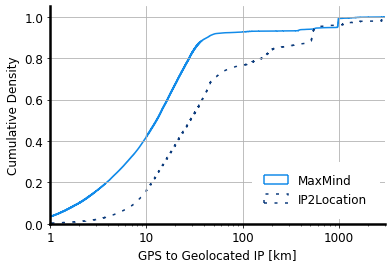

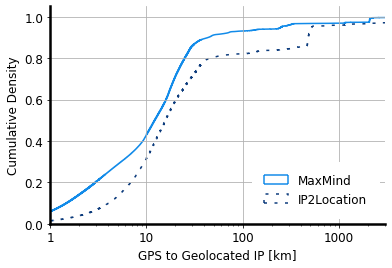

In [25]:
for k, v in city_ip.items():
    get_cdf_plot({"mm" : v.gps_mm_dist, "ip" : v.gps_ip_dist}, save = "acc_mm_v_ip2loc_" + k)

### Accuracy by Carrier

These are the big fish:

In [26]:
df_eval(lambda df: df.DBA.value_counts()).sort_values(by = "chicago", ascending = False).head(10)

,chicago,new_york
T-Mobile,4606423.0,12640073.0
ATT,3119312.0,2654853.0
Comcast,2669211.0,371557.0
Sprint,2301770.0,3434849.0
Verizon,1677817.0,6859850.0
RCN,196579.0,132453.0
WOW,126597.0,64.0
PSINet,22514.0,32827.0
SPC,20133.0,38641.0
DoD,18274.0,69345.0


In [27]:
big_fish = {"chicago"  : ["Comcast", "ATT", "Sprint", "T-Mobile", "Verizon"],
            "new_york" : ["Comcast", "ATT", "Sprint", "T-Mobile", "Verizon", "Charter", "Cablevision", "RCN"]
           }

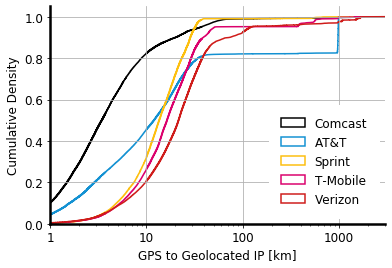

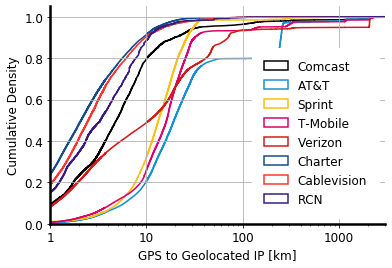

In [28]:
to_key = lambda x: x.lower().replace("-", "")

for city, df in city_ip.items():
    
    get_cdf_plot({to_key(k) : df.query("DBA == '{}'".format(k)).gps_mm_dist for k in big_fish[city]}, 
                 save = "acc_mm_by_carrier_" + city)

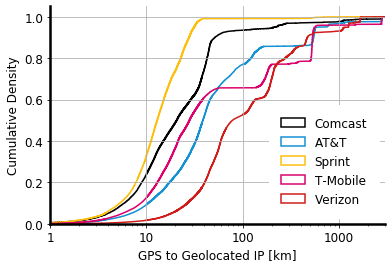

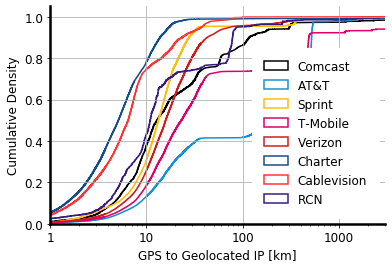

In [29]:
to_key = lambda x: x.lower().replace("-", "")

for city, df in city_ip.items():
    
    get_cdf_plot({to_key(k) : df.query("DBA == '{}'".format(k)).gps_ip_dist for k in big_fish[city]}, 
                 save = "acc_ip_by_carrier_" + city)

### MaxMind Claimed Accuracy

In [40]:
mm_accuracy = df_eval(lambda df: df.mm_acc.value_counts().sort_index())
mm_accuracy /= mm_accuracy.sum()
mm_accuracy.round(3)

,chicago,new_york
1.0,0.079,0.167
5.0,0.161,0.089
10.0,0.015,0.032
20.0,0.011,0.165
50.0,0.058,0.069
100.0,0.090,0.018
200.0,0.126,0.415
500.0,0.414,0.011
1000.0,0.046,0.033


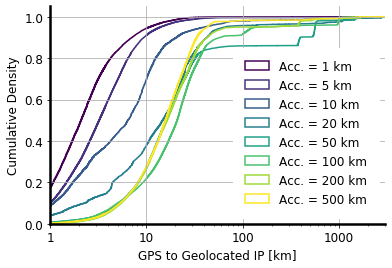

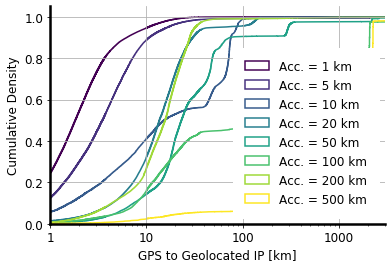

In [41]:
for city, df in city_ip.items():

    get_cdf_plot({"Acc. = {:d} km".format(k) : df.query("mm_acc == {}".format(k)).gps_mm_dist
                  for k in [1, 5, 10, 20, 50, 100, 200, 500]}, 
                 cmap = "viridis", save = "acc_by_mm_acc_" + city)

They are clearly aware of the different structures, by carrier.

In [42]:
big_fish_new_york = big_fish['new_york']

mm_acc_cuts = new_york_ip.query("DBA in @big_fish_new_york")\
                         .groupby(["DBA", "mm_acc"]).mm_acc.count() / \
              new_york_ip.groupby("DBA").mm_acc.count()

mm_acc_cuts.unstack().fillna(0).round(2)

mm_acc,1.0,5.0,10.0,20.0,50.0,100.0,200.0,500.0,1000.0
DBA,,,,,,,,,
ATT,0.00,0.00,0.00,0.00,0.00,0.01,0.79,0.01,0.19
Cablevision,0.56,0.36,0.03,0.03,0.01,0.00,0.00,0.00,0.00
Charter,0.63,0.29,0.04,0.02,0.01,0.01,0.00,0.00,0.01
Comcast,0.16,0.53,0.18,0.08,0.01,0.03,0.00,0.00,0.01
RCN,0.47,0.31,0.11,0.05,0.01,0.01,0.00,0.00,0.03
Sprint,0.00,0.00,0.00,0.92,0.01,0.06,0.01,0.00,0.00
T-Mobile,0.00,0.00,0.00,0.05,0.02,0.02,0.89,0.01,0.00
Verizon,0.31,0.11,0.08,0.17,0.27,0.01,0.00,0.02,0.04


### MaxMind vs IP2Location, by Carrier

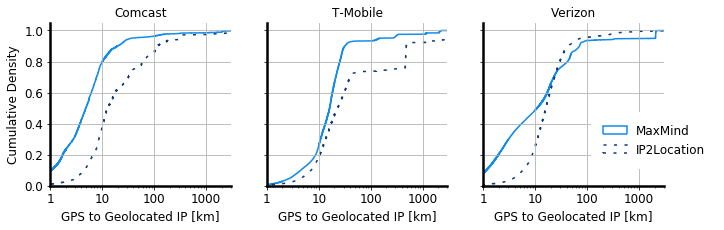

In [43]:
fig, ax = plt.subplots(1, 3, figsize = (11, 3), sharey = True)

for i, c in enumerate(["Comcast", "T-Mobile", "Verizon"]):
    get_cdf_plot({"mm" : new_york_ip.query("DBA == '{}'".format(c)).gps_mm_dist, 
                  "ip" : new_york_ip.query("DBA == '{}'".format(c)).gps_ip_dist}, 
                 ax = ax[i], leg = False)
    
    ax[i].set_title(c)
    if i: ax[i].set_ylabel("")
    
leg3_args = {"bbox_to_anchor" : (0.56, 0.07), "loc" : 'lower left', "frameon" : True}

ax[2].legend(**leg3_args)

fig.savefig("figs/acc_by_carrier_facet_new_york.pdf")

### A Typology of Clusters from the Geographic Extent

In [44]:
chicago_ip.dropna()[["gps_mm_dist", "gps_ip_dist"]].median()

gps_mm_dist    12.759096
gps_ip_dist    28.506122
dtype: float64

In [45]:
big_fish_chicago = big_fish["chicago"]

chicago_ip.query("DBA in @big_fish_chicago")\
          .groupby("DBA")[["gps_mm_dist", "gps_ip_dist"]].median()\
          .sort_values(by = "gps_mm_dist")

,gps_mm_dist,gps_ip_dist
DBA,,
Comcast,3.434161,20.640988
ATT,11.996829,38.592365
Sprint,13.585743,12.979799
T-Mobile,16.369635,27.991646
Verizon,21.561303,78.392115


But if we choose some of the geographically localized clusters from Comcast -- with multiple addresses per subnet! -- the accuracies are way, way better.

In [46]:
localized_subnets = ["98.222.252.0", "98.227.229.0", "73.209.252.0", "50.200.11.0", "76.16.225.0", 
                     "98.206.197.0", "24.14.202.0",  "24.1.42.0",    "24.1.164.0", "67.175.34.0"]

chicago_ip["localized_comcast"] = chicago_ip.subnet.isin(localized_subnets)
chicago_ip.query("localized_comcast").groupby("subnet")[["gps_mm_dist", "gps_ip_dist"]].median()

,gps_mm_dist,gps_ip_dist
subnet,,
24.1.164.0,3.523487,40.867905
24.1.42.0,2.693924,40.473671
24.14.202.0,6.291411,7.361146
50.200.11.0,2.736522,14.717078
67.175.34.0,1.412609,5.232701
73.209.252.0,3.503578,15.351523
76.16.225.0,1.942886,35.734719
98.206.197.0,4.094657,14.579428
98.222.252.0,1.933339,26.007473


### Subnet Scale

chicago
new_york


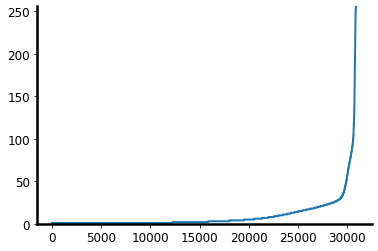

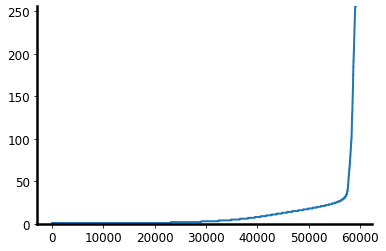

In [55]:
ip_per_subnet = {}
for city, df in city_ip.items():

    print(city)
    ip_per_subnet[city] = df.groupby("subnet").ip_address.apply(pd.Series.nunique).sort_values()
    
    fig, ax = plt.subplots()
    ip_per_subnet[city].reset_index(drop = True).plot(ax = ax)
    ax.set_ylim(0, 256)

\> 80% of addresses have are on subnets with at least 10 addresses.

In [56]:
{city : ip_per_subnet[city][ip_per_subnet[city] >= 10].sum() / ip_per_subnet[city].sum()
 for city in ["new_york", "chicago"]}

{'new_york': 0.8448617524586621, 'chicago': 0.8175830147044206}

But only one quarter of subnets have at least 10 addresses.

In [57]:
{city : ip_per_subnet[city][ip_per_subnet[city] >= 10].shape[0] / ip_per_subnet[city].shape[0]
 for city in ["new_york", "chicago"]}

{'new_york': 0.2962038551697388, 'chicago': 0.2560951949815689}

This is higher in large networks...

In [58]:
def ip_per_big_net(city):
    
    big_nets = big_fish[city]
    ip_per_subnet_big5 = city_ip[city].query("DBA in @big_nets").groupby("subnet").ip_address.apply(pd.Series.nunique)
    
    return ip_per_subnet_big5[ip_per_subnet_big5 >= 10].shape[0] / ip_per_subnet_big5.shape[0]
    
    
{ city : ip_per_big_net(city) for city in ["new_york", "chicago"]}

{'new_york': 0.38386062717770036, 'chicago': 0.30924170616113744}

Or 40% for Comcast in Chicago (22% in NYC).  So about half the subnets seem to have enough data that we could start to think about saying where the subnet was...

In [59]:
ip_per_subnet_charter = new_york_ip.query("DBA == 'Charter'").groupby("subnet").ip_address.apply(pd.Series.nunique)

ip_per_subnet_charter_10 = ip_per_subnet_charter[ip_per_subnet_charter >= 10]
comcast_active_nets = set(ip_per_subnet_charter_10.index)

ip_per_subnet_charter_10.shape[0] / ip_per_subnet_charter.shape[0]

0.4077531298045245

In [60]:
comcast_active_nets = new_york_ip.query("subnet in @comcast_active_nets")

In [61]:
def subnet_scale(G, frac):
    
    Gxy = G[["x", "y"]].astype(int).copy()
    xctr, yctr = Gxy.mean()

    Gxy["dctr"] = np.sqrt((Gxy.x - xctr)**2 + (Gxy.y - yctr)**2)
    Gxy.sort_values("dctr", inplace = True)
    Gxy.reset_index(drop = True, inplace = True)
    
    N = int(Gxy.shape[0] * frac)

    xy = gpd.GeoSeries([Point(xy) for xy in Gxy[:N].values])
    
    return np.sqrt(xy.unary_union.convex_hull.area) / 1e3


comcast_subnet_scale = {}
for frac in [0.25, 0.50, 0.75, 0.90, 1.00]:
    
    print(frac, end = " ", flush = True)
    
    comcast_subnet_scale[frac] = comcast_active_nets.groupby("subnet").apply(subnet_scale, frac = frac)
    
    comcast_subnet_scale[frac].sort_values(inplace = True)
    comcast_subnet_scale[frac].reset_index(inplace = True, drop = True)

0.25 0.5 0.75 0.9 1.0 

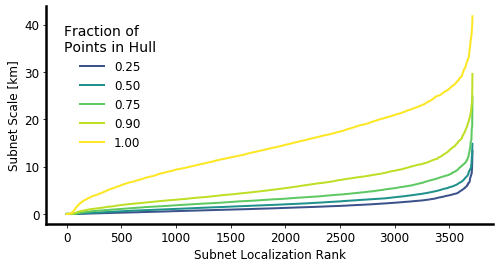

In [62]:
fig, ax = plt.subplots(figsize = (8, 4))

cmap = plt.get_cmap("viridis")

for frac in [0.25, 0.50, 0.75, 0.90, 1.00]:
    
    comcast_subnet_scale[frac].plot(label = "{:.2f}".format(frac), color = cmap(frac))
    
ax.set_xlabel("Subnet Localization Rank")
ax.set_ylabel("Subnet Scale [km]")
    
ax.legend(title = "Fraction of\nPoints in Hull",
          title_fontsize = 14)


### Looking at geography...

In [51]:
city = "new_york"
city_tracts_sql = """
SELECT pl.state, pl.name, tr18.geoid, tr18.geom geom
FROM   census_tracts_2018 tr18, census_place_2018 pl
WHERE 
  pl.name = '{}' AND
  pl.state = tr18.state AND pl.top20 AND
  ST_Intersects(tr18.geom, pl.geom) AND
  ST_Area(ST_Intersection(tr18.geom, pl.geom)) > ST_Area(tr18.geom) / 2;
""".format(city.title().replace("_", " "))

all_tracts_sql = "SELECT geoid, geom FROM census_tracts_2018;"

geo_tracts = gpd.read_postgis(all_tracts_sql, 
                              con = cen_con, index_col = "geoid", geom_col = "geom", 
                              crs = from_epsg(2163)).to_crs(epsg = 3528)

city_tracts = set(geo_tracts.index)

In [52]:
mm_tract_medians = city_ip[city].query('(DBA == "Cablevision")').groupby("geoid").gps_mm_dist.quantile(0.5)
mm_tract_medians = geo_tracts.join(mm_tract_medians, how = "inner")

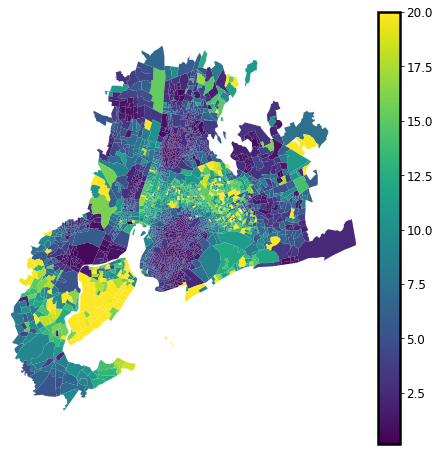

In [53]:
ax = mm_tract_medians.plot(column = "gps_mm_dist", vmax = 20, figsize = (6, 6), legend = True)

map_format(ax)

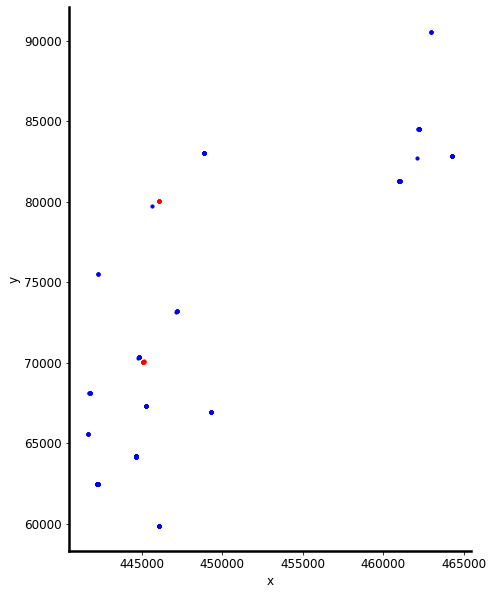

In [54]:
fig, ax = plt.subplots(subplot_kw = {"aspect" : "equal"}, figsize = (10, 10))

city_ip[city].query('(DBA == "Comcast") & (gps_ip_dist < 0.05)')\
             .plot(x = "x", y = "y", kind = "scatter", color = "r", s = 10, ax = ax)

city_ip[city].query('(DBA == "Comcast") & (gps_mm_dist < 0.05)')\
             .plot(x = "x", y = "y", kind = "scatter", color = "b", s = 10, ax = ax)

## Outliers in Chicago

### MaxMind

MaxMind's default location points to [Cheney Reservoir, Kansas](https://splinternews.com/this-is-the-new-digital-center-of-the-united-states-1793856143).  This seems, in particular, to affect the AT&T points, nearly 18% of which are geocoded there.

In [30]:
chicago_ip.query("(DBA == 'ATT') & (950 < gps_mm_dist) & (gps_mm_dist < 990)")[["mm_lat", "mm_lon"]].median()

mm_lat    37.751
mm_lon   -97.822
dtype: float64

Pretty much the entire 107.77.173.0 subnet is coded there (does it show up in NYC, too)?  Note that 107.64.0.0/10 is [allocated](https://whois.arin.net/rest/net/NET-107-64-0-0-1/pft?s=107.77.173.0) to AT&T Mobility LLC, whereas the most common _really_ close ones (distance < 1 km) are allocated to AT&T Corp, e.g., [70.235.128.0](https://whois.arin.net/rest/net/NET-70-232-128-0-1/pft?s=70.235.128.0).

In [31]:
chicago_ip.query("(DBA == 'ATT') & (950 < gps_mm_dist) & (gps_mm_dist < 990)").subnet.value_counts().head(5)

107.77.173.0       511800
2600:387:b::         6688
107.77.172.0         1509
2602:306:bc1c::       885
2602:30a:2e78::       603
Name: subnet, dtype: int64

In [32]:
chicago_ip.query("(DBA == 'ATT') & (950 < gps_mm_dist) & (gps_mm_dist < 990)").ip_address.value_counts().head(5)

107.77.173.44    9281
107.77.173.31    9062
107.77.173.33    8988
107.77.173.62    8903
107.77.173.37    8861
Name: ip_address, dtype: int64

In [33]:
chicago_ip.query("(DBA == 'ATT') & (gps_mm_dist < 1)").subnet.value_counts().head(5) ## All AT&T Corp.

70.235.128.0     2292
162.233.155.0    1831
162.224.229.0    1614
162.237.30.0     1570
99.145.53.0      1438
Name: subnet, dtype: int64

#### Verizon 
For Verizon, the step-ups are less clear.  There is a big increase between 50 and 100 km, but while there are a few locations with a very large number of points, they do not appear to be particularly special.  For instance, the most common location, at (42.2571, -88.8535) has 30 thousand points and is coded down to the city (Belvidere, IL).  These also do not appear to be issues with the IP addresses registered in the GPS data, which are fairly diverse at that point (i.e., it is not just one user making all the trouble).  I guess that these are just other "sink" locations, as show up in the GPS data as well.

In [34]:
chicago_ip.query("(DBA == 'Verizon') & (50 < gps_mm_dist) & (gps_mm_dist < 100)")\
          .groupby(["mm_lat", "mm_lon"]).identifier.count().sort_values(ascending = False).head(3)

mm_lat   mm_lon  
42.2571  -88.8535    30485
42.0305  -88.3781    28677
42.1597  -88.1414    10752
Name: identifier, dtype: int64

In [35]:
chicago_ip.query("(DBA == 'Verizon') & (mm_lat == 42.2571)").ip_address.value_counts().head(5)

174.192.82.120    339
174.192.86.227    225
174.192.81.98     191
174.192.81.89     182
174.192.81.147    163
Name: ip_address, dtype: int64

In [36]:
chicago_ip.query("(DBA == 'Verizon') & (mm_lat == 42.2571)").identifier.value_counts().head(5)

0025165e-c5ea-4441-9ed8-0cf08b1c0245    328
377b0b02-d55f-4a35-a8b3-2b0d5d0e68c8    294
cc32f007-b0e8-4749-ae4e-6ef59bb9f7b1    273
65571841-303f-4902-8cf4-1b218277d3c9    175
0ecfd3ed-e28d-4e68-8343-32fd0443dfd7    158
Name: identifier, dtype: int64

#### T-Mobile
There is a large number of points, about 380 km from Chicago, geocoded to Detroit (metro pop 4.3M).  The first of these coordinates is along Detroit's northern edge, far from its "geographic center."  There's another substantial "rise" at 560 km from Chicago, corresponding to Minneapolis (metro pop 3.6M).  Indianapolis (≈265 km, 2.0M metro) and St Louis (≈420 km, 2.8M metro) see no notable jumps -- perhaps at least in part relating to their smaller populations (smaller infrastructures, and fewer people travelling there).

In [37]:
chicago_ip.query("(DBA == 'T-Mobile') & (360 < gps_mm_dist) & (gps_mm_dist < 400)")\
          .groupby(["mm_lat", "mm_lon"]).identifier.count().sort_values(ascending = False).head(3)

mm_lat   mm_lon  
42.4257  -83.1522    41271
42.3673  -83.1329    24573
42.4261  -83.2514      758
Name: identifier, dtype: int64

In [38]:
chicago_ip.query("(DBA == 'T-Mobile') & (500 < gps_mm_dist) & (gps_mm_dist < 600)")\
          .groupby(["mm_lat", "mm_lon"]).identifier.count().sort_values(ascending = False).head(3)

mm_lat   mm_lon  
44.9402  -93.2188    67064
37.8395  -85.1321     2651
41.4781  -81.5746     1003
Name: identifier, dtype: int64

Similarly, if we keep to the city, the T-Mobile points are geolocated to just a few locations

In [39]:
tmobile_chicago = chicago_ip.query("(DBA == 'T-Mobile') & (gps_mm_dist < 50)")
tmobile_chicago.groupby(["mm_lat", "mm_lon"]).identifier.count().sort_values(ascending = False).head(3) / tmobile_chicago.shape[0]

mm_lat   mm_lon  
41.9984  -87.7108    0.657485
41.8502  -87.6736    0.313169
41.8883  -87.7613    0.003866
Name: identifier, dtype: float64

### IP2Location

For devices in Chicago, IP2Location locates significant fractions of points to Akron, OH, Lafayette, IN, and Seattle WA (!!).

In [83]:
chicago_ip.query('(DBA == "T-Mobile") & (gps_ip_dist > 50)')\
          .groupby(["ip2loc_lat", "ip2loc_lon"]).identifier.count().sort_values(ascending = False).head(3)

ip2loc_lat  ip2loc_lon 
41.081440   -81.519012     731414
40.425869   -86.908073     524884
47.610378   -122.200684    165938
Name: identifier, dtype: int64

For Verizon, the most common points are Crown Point, IN, Peoria, IL, and South Bend IN.  

In [84]:
chicago_ip.query('(DBA == "Verizon") & (gps_ip_dist > 50)')\
          .groupby(["ip2loc_lat", "ip2loc_lon"]).identifier.count().sort_values(ascending = False).head(3)

ip2loc_lat  ip2loc_lon
41.416981   -87.365311    90599
40.693649   -89.588989    78409
41.683380   -86.250008    65254
Name: identifier, dtype: int64

For AT&T it's Woodstock IL, Eagan MN, and Milwaukee WI.

In [97]:
chicago_ip.query('(DBA == "ATT") & (gps_ip_dist > 100)')\
          .groupby(["ip2loc_lat", "ip2loc_lon"]).identifier.count().sort_values(ascending = False).head(5)

ip2loc_lat  ip2loc_lon 
44.804131   -93.166893     257888
43.038898   -87.906471     252215
47.673988   -122.121513     54541
35.149529   -90.048981      44797
42.314739   -88.448700      19772
Name: identifier, dtype: int64

But to a certain extent, these just aren't that interesting -- we know the cell networks are wildly wrong.

So let's focus on Comcast.  

They _can_ make big mistakes for Comcasttoo -- there is a significant fraction of devices mis-located to Indianapolis, and smaller numbers in Champaign IL or South Bend IN.

In [100]:
chicago_ip.query('(DBA == "Comcast") & (100 < gps_ip_dist) & (gps_ip_dist < 400)')\
          [["ip2loc_lat", "ip2loc_lon"]].round(2).groupby(["ip2loc_lat", "ip2loc_lon"])\
          .ip2loc_lon.count().sort_values(ascending = False).head(3)

ip2loc_lat  ip2loc_lon
39.77       -86.16        37743
40.12       -88.24         9319
41.68       -86.25         5604
Name: ip2loc_lon, dtype: int64

What can we say about the mis-located subnets in Indianapolis?

In [103]:
chicago_ip.query("(abs(ip2loc_lat - 39.77) < 0.05) & (abs(ip2loc_lon - -86.16) < 0.05)")\
          .subnet.value_counts().head()

71.194.94.0     1688
98.226.145.0    1396
73.72.209.0     1371
73.111.72.0     1272
73.8.173.0      1220
Name: subnet, dtype: int64

Nothing particularly special about them, except that they're wrong!  In several cases, the whois CIDR range is even named Illinois-# or Chicago-CPE-#!

## Outliers from New York

### MaxMind

MaxMind makes its AT&T mistakes to Amsterdam NY, and its T-Mobile mistakes to Boston.  Both T-Mobile and Comcast have some un-located points "at" Cheney Reservoir (37.751, -97.822), but there are no other significant Comcast "mistakes."

In [121]:
new_york_ip.query('(DBA == "ATT") & (gps_mm_dist > 100)')\
           .groupby(["mm_lat", "mm_lon"]).identifier.count().sort_values(ascending = False).head(3)

mm_lat   mm_lon  
42.9380  -74.1853    444223
37.7510  -97.8220     26826
33.8743  -84.4653     20596
Name: identifier, dtype: int64

In [122]:
new_york_ip.query('(DBA == "T-Mobile") & (gps_mm_dist > 100)')\
           .groupby(["mm_lat", "mm_lon"]).identifier.count().sort_values(ascending = False).head(3)

mm_lat   mm_lon  
42.3120  -71.1081    136583
37.7510  -97.8220    101286
40.0149  -75.1439     99445
Name: identifier, dtype: int64

In [125]:
new_york_ip.query('(DBA == "Comcast") & (gps_mm_dist > 100)')\
           [["mm_lat", "mm_lon"]].round(2).groupby(["mm_lat", "mm_lon"])\
           .mm_lat.count().sort_values(ascending = False).head(1)

mm_lat  mm_lon
37.75   -97.82    2402
Name: mm_lat, dtype: int64

### IP2Location

Most common errors for AT&T are Monroeville PA (!! - outside Pittsburgh), Pittsburgh itself, and Philadelphia.

In [106]:
new_york_ip.query('(DBA == "ATT") & (gps_ip_dist > 100)')\
           .groupby(["ip2loc_lat", "ip2loc_lon"]).identifier.count().sort_values(ascending = False).head(3)

ip2loc_lat  ip2loc_lon
40.421181   -79.788101    593114
40.440620   -79.995888    548837
39.952339   -75.163788    295360
Name: identifier, dtype: int64

T-Mobile sends its prime mistakes to Buffalo, North Tonawanda (near Buffalo), and again, Seattle.

In [112]:
new_york_ip.query('(DBA == "T-Mobile") & (gps_ip_dist > 100)')\
           .groupby(["ip2loc_lat", "ip2loc_lon"]).identifier.count().sort_values(ascending = False).head(3)

ip2loc_lat  ip2loc_lon 
42.886452   -78.878372     1318883
43.038670   -78.864197      663294
47.610378   -122.200684     649643
Name: identifier, dtype: int64

Comcast has mistakes to Arlington VA.

In [116]:
new_york_ip.query('(DBA == "Comcast") & (gps_ip_dist > 200) & (gps_ip_dist < 400)')\
           [["ip2loc_lat", "ip2loc_lon"]].round(2).groupby(["ip2loc_lat", "ip2loc_lon"])\
           .ip2loc_lon.count().sort_values(ascending = False).head(1)

ip2loc_lat  ip2loc_lon
38.88       -77.1         8722
Name: ip2loc_lon, dtype: int64

### To-do
* Comparison of Chicago with NYC (prep for LA, WV) -- **refactor the code**.
* Distance scale (diameter or √A) of /24, CIDR, or AS (after 90% of nearest?)
* Compare paid versions of MaxMind ([\$48 / month](https://www.maxmind.com/en/geoip2-city) for North America) and IP2Location ([\$349 / year](https://www.ip2location.com/buy-online) for DB5... why anyone would pay another \\$150 for the ISP lookup is nonsense!  possibly interesting is their NetSpeed -- cable/fiber/mobile/dial-up -- but unlikely reliable and pretty expensive -- \\$1500+).